## Loading data

pwd

In [18]:
%cd ..
%ll

/home
total 315416
drwxr-xr-x 11 root      4096 Jun 14 10:27  camvid/
-rw-r--r--  1 root 322961408 Jun 14 10:27  camvid.tgz
-rw-r--r--  1 root      8854 Jun 14 09:56 'object?spm=5176.8466032.list-of-files-normal.dgo-dir.79451450QLnAMV'
-rw-r--r--  1 root      1541 Jun 14 09:56  wget-log


In [19]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [33]:
DATA_DIR = 'camvid'

x_train_dir = os.path.join(DATA_DIR, 'images')
y_train_dir = os.path.join(DATA_DIR, 'labels')

x_valid_dir = os.path.join(DATA_DIR, 'valid_images')
y_valid_dir = os.path.join(DATA_DIR, 'valid_labels')

x_test_dir = os.path.join(DATA_DIR, 'test_images')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')


In [34]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [35]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [36]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            augmentation=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        self.augmentation = augmentation

    
    def __getitem__(self, i):
                
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # sky
        mask = (mask==17)
        mask = mask.astype('float')   
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask.reshape(1,320,320)
        
    def __len__(self):
        return len(self.ids)

### Augmentations

In [37]:
import albumentations as albu

0 255


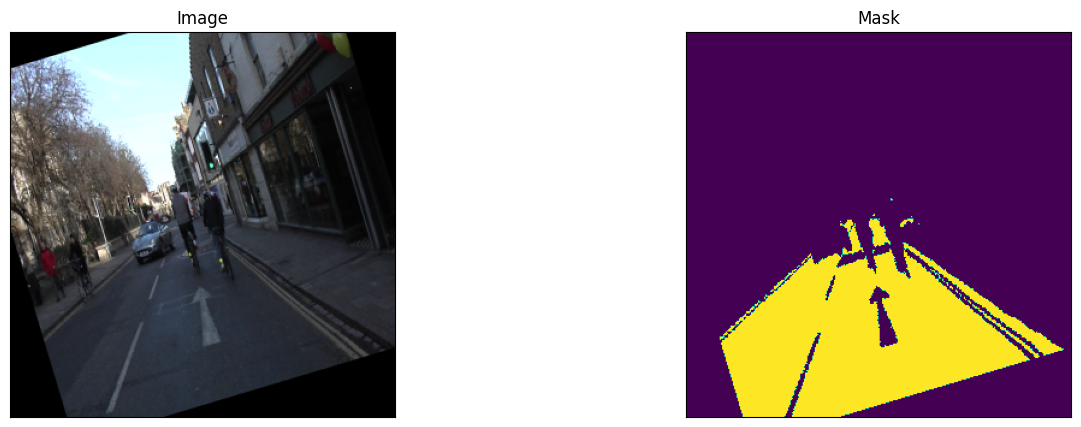

In [38]:
#### Visualize resulted augmented images and masks

def get_training_augmentation():
    train_transform = [
        albu.HorizontalFlip(p=0.5),
        albu.Resize(height=320, width=320, always_apply=True),
        albu.ShiftScaleRotate(scale_limit=0.1, rotate_limit=20, shift_limit=0.1, p=1, border_mode=0),
    ]
    return albu.Compose(train_transform)

def get_test_augmentation():
    train_transform = [
        albu.Resize(height=320, width=320, always_apply=True),
    ]
    return albu.Compose(train_transform)                                         

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
)

# same image with different random transforms
for i in range(1):
    image, mask = augmented_dataset[1]
    print(np.min(image),np.max(image))
    visualize(image=image, mask=mask[0,:,:])

## Create model and train

In [39]:
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

In [40]:
#这段代码是一个基于U-Net的卷积神经网络模型，用于图像分割任务。其中包含了三个类：DoubleConv、Down和Up。
#DoubleConv类定义了一个双卷积层，包括两个卷积层、Batch Normalization和ReLU激活函数。
#Down类定义了一个下采样层，包括一个最大池化层和一个双卷积层。
#Up类定义了一个上采样层，包括一个上采样操作和一个双卷积层。
#其中，上采样操作可以选择使用双线性插值或转置卷积来实现。
#在forward函数中，输入x1和x2是两个特征图，x1经过上采样操作后与x2进行拼接，并进行双卷积操作。

In [41]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = torch.tensor([x2.size()[2] - x1.size()[2]])
        diffX = torch.tensor([x2.size()[3] - x1.size()[3]])

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [42]:
#这是一个PyTorch实现的U-Net结构，通常用于图像分割任务。
#U-Net结构是一个完全卷积神经网络，由编码器路径和解码器路径组成，
#其中编码器和解码器之间有相应级别的跳跃连接。
#编码器路径用于捕获图像的上下文信息，而解码器路径用于恢复编码过程中丢失的空间信息。
#该结构包含下采样层（Down），用于降低特征图的空间维度，以及上采样层（Up），用于增加特征图的空间维度。
#DoubleConv模块由两个3x3卷积层和一个ReLU激活函数组成。
#OutConv模块是一个最终的卷积层，用于产生输出的logits，sigmoid函数应用于logits以获得最终输出。

In [43]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 32)
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        self.down4 = Down(256, 256)
        self.up1 = Up(512, 128, bilinear)
        self.up2 = Up(256, 64, bilinear)
        self.up3 = Up(128, 32, bilinear)
        self.up4 = Up(64, 32, bilinear)
        self.outc = OutConv(32, n_classes)
        self.out  = torch.sigmoid
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        logits = self.out(logits)
        return logits

In [44]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
)

# valid_dataset = Dataset(
#     x_valid_dir, 
#     y_valid_dir, 
#     augmentation=augmentation, 
# )

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
# valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

In [45]:
net = UNet(n_channels=3, n_classes=1)

torch.Size([3, 320, 320])
(1, 320, 320)
0.0 1.0


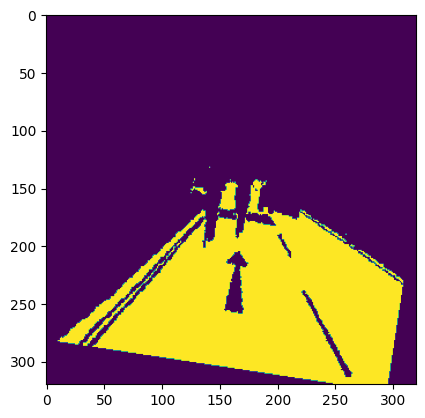

torch.Size([1, 1, 320, 320])
0.110947065 0.9735416


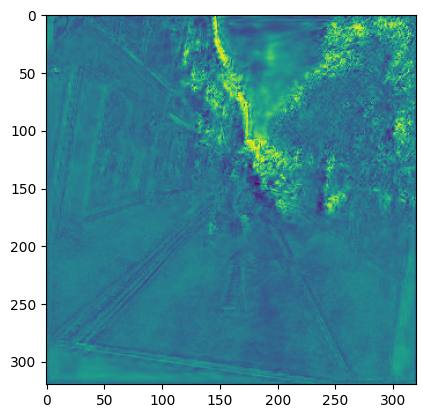

In [46]:
image, mask = train_dataset[1]
with torch.no_grad():
    net.to('cuda')
    image = image/255.
    image = image.astype('float32')
    image = torch.from_numpy(image)
    image = image.permute(2,0,1)
    image = image.to()
    print(image.shape)
    
    #pred = torch.argmax(pred, dim=1).squeeze().numpy()
    pred = net(image.unsqueeze(0).cuda())
    pred = pred.cpu()

plt.figure('mask')
print(mask.shape)
print(np.min(mask),np.max(mask))
plt.imshow(mask[0,:,:])
plt.show()

plt.figure('pred')
# pred = pred.view(720,960)
print(pred.shape)
print(np.min(pred.numpy()),np.max(pred.numpy()))
plt.imshow(pred[0,0,:,:])
plt.show()

In [ ]:
#源代码

In [47]:
from torch.autograd import Variable
net.cuda()

optimizer = optim.RMSprop(net.parameters(), lr=0.001, weight_decay=1e-8)
criterion = nn.BCELoss()

# 40  0.01
# 40 0.005
# 20 0.001
device = 'cuda'
for epoch in range(100):
    
    net.train()
    epoch_loss = 0
    
    for data in train_loader:
        
        images,labels = data
        images = images.permute(0,3,1,2)
        images = images/255.
        images = Variable(images.to(device=device, dtype=torch.float32))
        labels = Variable(labels.to(device=device, dtype=torch.float32))
        

        pred = net(images)
        
        # wrong to use loss = criterion(pred.view(-1), labels.view(-1))
        loss = criterion(pred, labels)
        epoch_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print('loss: ', loss.item())
    

loss:  0.7029664516448975
loss:  0.6680219173431396
loss:  0.5767873525619507
loss:  0.5689879059791565
loss:  0.4805818796157837
loss:  0.4716285467147827
loss:  0.3905055820941925
loss:  0.3491983711719513
loss:  0.4735124409198761
loss:  0.5480230450630188
loss:  0.42934706807136536
loss:  0.4315929710865021
loss:  0.37570619583129883
loss:  0.35394126176834106
loss:  0.31528952717781067
loss:  0.3928169906139374
loss:  0.3814355432987213
loss:  0.3468419909477234
loss:  0.3083786964416504
loss:  0.3315117061138153
loss:  0.31469106674194336
loss:  0.3117329776287079
loss:  0.30272796750068665
loss:  0.25042223930358887
loss:  0.24037650227546692
loss:  0.24229884147644043
loss:  0.25453847646713257
loss:  0.304584264755249
loss:  0.3415204584598541
loss:  0.34121379256248474
loss:  0.3365803360939026
loss:  0.2556339502334595
loss:  0.27952608466148376
loss:  0.2823730707168579
loss:  0.30726152658462524
loss:  0.2572645843029022
loss:  0.24574393033981323
loss:  0.2482258677482605

error: OpenCV(4.7.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [ ]:
添加loss曲线记录

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:54: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


epoch: 0, loss: 20.222021110355854
epoch: 1, loss: 12.082196824252605
epoch: 2, loss: 10.33458910137415
epoch: 3, loss: 9.308400690555573
epoch: 4, loss: 9.01604038476944
epoch: 5, loss: 8.101756006479263
epoch: 6, loss: 7.858697012066841
epoch: 7, loss: 9.668701019138098
epoch: 8, loss: 7.0931806564331055
epoch: 9, loss: 6.891055945307016
epoch: 10, loss: 6.305045295506716
epoch: 11, loss: 7.134603478014469
epoch: 12, loss: 6.21277404949069
epoch: 13, loss: 5.562761884182692
epoch: 14, loss: 5.623151566833258
epoch: 15, loss: 5.190786547958851
epoch: 16, loss: 5.381020855158567
epoch: 17, loss: 5.353804487735033
epoch: 18, loss: 4.85122861340642
epoch: 19, loss: 5.116985321044922
epoch: 20, loss: 4.762672141194344
epoch: 21, loss: 4.631125561892986
epoch: 22, loss: 4.70070431008935
epoch: 23, loss: 4.466016437858343
epoch: 24, loss: 4.7072881534695625
epoch: 25, loss: 4.426952801644802
epoch: 26, loss: 4.373289100825787
epoch: 27, loss: 5.017925951629877
epoch: 28, loss: 4.35644826665

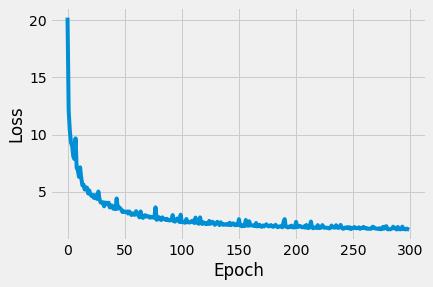

In [59]:
import matplotlib.pyplot as plt
from torch.autograd import Variable
net.cuda()

optimizer = optim.RMSprop(net.parameters(), lr=0.003, weight_decay=1e-8)
criterion = nn.BCELoss()
# 创建空列表
loss_list = []

for epoch in range(300):
    
    net.train()
    epoch_loss = 0
    
    for data in train_loader:
        
        images,labels = data
        images = images.permute(0,3,1,2)
        images = images/255.
        images = Variable(images.to(device=device, dtype=torch.float32))
        labels = Variable(labels.to(device=device, dtype=torch.float32))
        

        pred = net(images)
        
        # wrong to use loss = criterion(pred.view(-1), labels.view(-1))
        loss = criterion(pred, labels)
        epoch_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # 将每个epoch的loss添加到列表中
    loss_list.append(epoch_loss)
    print('epoch: {}, loss: {}'.format(epoch, epoch_loss))

# 绘制loss曲线
plt.plot(loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [ ]:
loss曲线以及权重保存

In [48]:
import matplotlib.pyplot as plt
from torch.autograd import Variable
net.cuda()

optimizer = optim.RMSprop(net.parameters(), lr=0.003, weight_decay=1e-8)
criterion = nn.BCELoss()
# 创建空列表
loss_list = []
device = 'cuda'
for epoch in range(100):
    
    net.train()
    epoch_loss = 0
    
    for data in train_loader:
        
        images,labels = data
        images = images.permute(0,3,1,2)
        images = images/255.
        images = Variable(images.to(device=device, dtype=torch.float32))
        labels = Variable(labels.to(device=device, dtype=torch.float32))
        

        pred = net(images)
        
        # wrong to use loss = criterion(pred.view(-1), labels.view(-1))
        loss = criterion(pred, labels)
        epoch_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # 将每个epoch的loss添加到列表中
    loss_list.append(epoch_loss)
    print('epoch: {}, loss: {}'.format(epoch, epoch_loss))
# 保存模型的权重
torch.save(net.state_dict(), 'best_model_weights.pth')

# 绘制loss曲线
plt.plot(loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

error: OpenCV(4.7.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [ ]:
#多卡训练

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data.distributed
from torch.autograd import Variable
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.distributed as dist
import matplotlib.pyplot as plt

import os

os.environ['MASTER_ADDR'] = 'localhost'
os.environ['MASTER_PORT'] = '5678'


# 初始化分布式环境
dist.init_process_group(backend='nccl')
local_rank = torch.distributed.get_rank()
world_size = torch.distributed.get_world_size()

# 设置数据集和数据加载器
train_sampler = torch.utils.data.distributed.DistributedSampler(train_dataset, num_replicas=world_size, rank=local_rank)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)

# 创建模型并移动到GPU
net = UNNet()
net.cuda()
net = DDP(net)

# 创建优化器和损失函数
optimizer = optim.RMSprop(net.parameters(), lr=0.003, weight_decay=1e-8)
criterion = nn.BCELoss()

# 创建空列表
loss_list = []
device = 'cuda'

for epoch in range(3):
    
    train_sampler.set_epoch(epoch)
    net.train()
    epoch_loss = 0
    
    for data in train_loader:
        
        images,labels = data
        images = images.permute(0,3,1,2)
        images = images/255.
        images = Variable(images.to(device=device, dtype=torch.float32))
        labels = Variable(labels.to(device=device, dtype=torch.float32))
        

        pred = net(images)
        
        loss = criterion(pred, labels)
        epoch_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # 将每个epoch的loss添加到列表中
    loss_list.append(epoch_loss)
    print('epoch: {}, loss: {}'.format(epoch, epoch_loss))
    torch.distributed.barrier()

# 保存模型的权重
torch.save(net.module.state_dict(), 'best_model_weights.pth')

# 绘制loss曲线
plt.plot(loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


ValueError: Error initializing torch.distributed using env:// rendezvous: environment variable RANK expected, but not set

## Test model

In [14]:
test_dataset_noaug = Dataset(
    x_train_dir, 
    y_train_dir,
    augmentation=get_test_augmentation(),
    )

torch.Size([3, 320, 320])


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:54: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


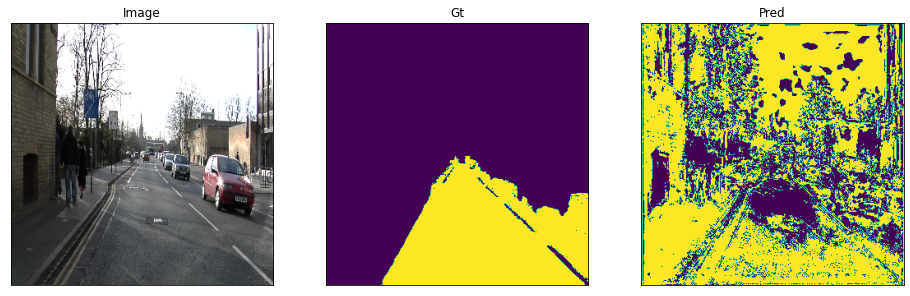

(1, 320, 320)
0.0 1.0


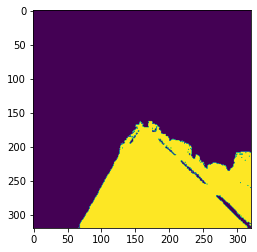

False True


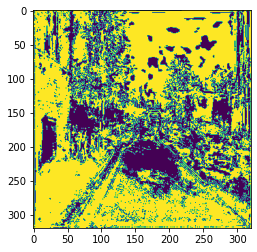

In [15]:
image, mask = test_dataset_noaug[120]
show_image = image
with torch.no_grad():
    image = image/255.
    image = image.astype('float32')
    image = torch.from_numpy(image)
    image = image.permute(2,0,1)
    image = image.to()
    print(image.shape)
    
    pred = net(image.unsqueeze(0).cuda())
    pred = pred.cpu()
    
pred = pred>0.5
visualize(image=show_image,GT=mask[0,:,:],Pred=pred[0,0,:,:])
    
plt.figure('mask')
print(mask.shape)
print(np.min(mask),np.max(mask))
plt.imshow(mask[0,:,:])
plt.show()

#plt.figure('pred')
#pred = pred.view(720,960)
#print(pred.shape)

pred = pred>0.8
print(np.min(pred.numpy()),np.max(pred.numpy()))
plt.imshow(pred[0,0,:,:])
plt.show()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:54: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


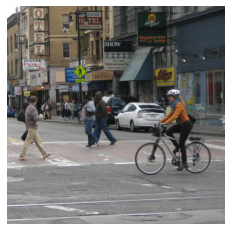

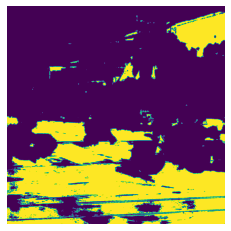

In [21]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Load the pre-trained model
#net = UNet()
net = UNet(n_channels=3, n_classes=1)
net.load_state_dict(torch.load('best_model_weights.pth'))

# Load the test image
#image = Image.open('/root/Test/camvid/camvid/test_images/0006R0_f03300.png')
image = Image.open('/root/Test/unet/data/images/street.jpg')

# Preprocess the image
image = np.array(image)
image = image / 255.
image = image.astype('float32')
image = torch.from_numpy(image)
image = image.permute(2,0,1)
image = image.unsqueeze(0)

# Make a prediction on the preprocessed image using the loaded model
with torch.no_grad():
    pred = net(image)

# Threshold the predicted output at 0.5
pred = pred > 0.5

# Visualize the original image and predicted mask
plt.figure('Original Image')
plt.imshow(image.squeeze().permute(1,2,0))
plt.axis('off')

plt.figure('Predicted Mask')
plt.imshow(pred.squeeze().cpu().numpy())
plt.axis('off')

plt.show()


In [24]:
import cv2
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Load the pre-trained model
net = UNet(n_channels=3, n_classes=1)
net.load_state_dict(torch.load('best_model_weights.pth'))

# Open the video file
cap = cv2.VideoCapture('/root/Test/camvid/camvid/city.mp4')

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output.mp4', fourcc, 20.0, (640,480))

while(cap.isOpened()):
    # Read a frame from the video file
    ret, frame = cap.read()

    if ret == True:
        # Convert the frame to a PIL image
        image = Image.fromarray(frame)

        # Preprocess the image
        image = np.array(image)
        image = image / 255.
        image = image.astype('float32')
        image = torch.from_numpy(image)
        image = image.permute(2,0,1)
        image = image.unsqueeze(0)

        # Make a prediction on the preprocessed image using the loaded model
        with torch.no_grad():
            pred = net(image)

        # Threshold the predicted output at 0.5
        pred = pred > 0.5

        # Convert the predicted mask to a numpy array and resize it to match the frame size
        mask = pred.squeeze().cpu().numpy()
        mask = cv2.resize(mask, (frame.shape[1], frame.shape[0]))
    
        # Apply the mask to the original frame and write the result to the output video file
        result = cv2.bitwise_and(frame, frame, mask=mask.astype(np.uint8)*255)
        out.write(result)

        # Display the result
        cv2.imshow('Result', result)

        # Press 'q' to exit
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    else:
        break

# Release everything if job is finished
cap.release()
out.release()
cv2.destroyAllWindows()


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:54: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


TypeError: Expected Ptr<cv::UMat> for argument 'src'

In [ ]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

# Load the pre-trained model
net = UNet(n_channels=3, n_classes=1)
net.load_state_dict(torch.load('best_model_weights.pth'))

# Open the video file
cap = cv2.VideoCapture('/root/Test/camvid/camvid/city.mp4')
# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output1.mp4', fourcc, 20.0, (640,480))
# Loop through the frames of the video
while True:
    # Read the next frame
    ret, frame = cap.read()
    if not ret:
        break

    # Convert the frame to a PIL image
    image = Image.fromarray(frame)

    # Preprocess the image
    image = np.array(image)
    image = image / 255.
    image = image.astype('float32')
    image = torch.from_numpy(image)
    image = image.permute(2,0,1)
    image = image.unsqueeze(0)

    # Make a prediction on the preprocessed image using the loaded model
    with torch.no_grad():
        pred = net(image)

    # Threshold the predicted output at 0.5
    pred = pred > 0.5

    # Convert the predicted mask to a numpy array
    mask = pred.squeeze().cpu().numpy()

    # Apply the mask to the original frame
    #masked_frame = cv2.bitwise_and(frame, frame, mask=mask.astype(np.uint8))
    masked_frame = cv2.bitwise_and(frame, frame, mask=mask.astype(np.uint8)*255)
    out.write(masked_frame)
    # Display the original frame and masked frame
    #cv2.imshow('Original Frame', frame)
    #cv2.imshow('Masked Frame', masked_frame)

    # Exit if the user presses 'q'
    #if cv2.waitKey(1) & 0xFF == ord('q'):
        #break

# Release the video capture object and close all windows
cap.release()
out.release()
cv2.destroyAllWindows()
print("over")

In [26]:
import time
import cv2
import numpy as np
from PIL import Image

if __name__ == "__main__":

    net = UNet(n_channels=3, n_classes=1)
    #unet.model_path = 'best_model_weights.pth'
    net = UNet(n_channels=3, n_classes=1)
    net.load_state_dict(torch.load('best_model_weights.pth'))

    mode = "predict"

    # -------------------------------------------------------------------------#
    #   count               指定了是否进行目标的像素点计数（即面积）与比例计算
    #   name_classes        区分的种类，和json_to_dataset里面的一样，用于打印种类和数量
    #
    #   count、name_classes仅在mode='predict'时有效
    # -------------------------------------------------------------------------#
    count = False
    name_classes = ["background", "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow",
                    "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train",
                    "tvmonitor"]
    
    video_path = "/root/Test/camvid/camvid/city.mp4"
    video_save_path = ""
    video_fps = 25.0

    # ----------------------------------------------------------------------------------------------------------#
    #   test_interval       用于指定测量fps的时候，图片检测的次数。理论上test_interval越大，fps越准确。
    #   fps_image_path      用于指定测试的fps图片
    #
    #   test_interval和fps_image_path仅在mode='fps'有效
    # ----------------------------------------------------------------------------------------------------------#
    test_interval = 100
    fps_image_path = "/root/Test/camvid/camvid/images/0001TP_007860.png"

    # -------------------------------------------------------------------------#
    #   dir_origin_path     指定了用于检测的图片的文件夹路径
    #   dir_save_path       指定了检测完图片的保存路径
    #
    #   dir_origin_path和dir_save_path仅在mode='dir_predict'时有效
    # -------------------------------------------------------------------------#
    dir_origin_path = "//root/Test/camvid/camvid/images/0001TP_007860.png"
    dir_save_path = "img_out/"

    # -------------------------------------------------------------------------#
    #   simplify            使用Simplify onnx
    #   onnx_save_path      指定导出onnx时的保存路径
    #
    #   simplify和onnx_save_path仅在mode='export_onnx'时有效
    # -------------------------------------------------------------------------#
    simplify = True
    onnx_save_path = 'model_data/unet.onnx'


    if mode == "predict":
        

        # img = input('Input image filename:')
        img = "/root/Test/camvid/camvid/images/0001TP_007860.png"
        try:
            image = Image.open(img)
        except:
            print('Open Error! Try again!')

        
    elif mode == "video":
        capture = cv2.VideoCapture(video_path)
        if video_save_path != "":
            fourcc = cv2.VideoWriter_fourcc(*'XVID')
            size = (int(capture.get(cv2.CAP_PROP_FRAME_WIDTH)), int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT)))
            out = cv2.VideoWriter(video_save_path, fourcc, video_fps, size)

        ref, frame = capture.read()
        if not ref:
            raise ValueError("未能正确读取摄像头（视频），请注意是否正确安装摄像头（是否正确填写视频路径）。")

        fps = 0.0
        while (True):
            t1 = time.time()
            # 读取某一帧
            ref, frame = capture.read()
            if not ref:
                break
            # 格式转变，BGRtoRGB
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            # 转变成Image
            frame = Image.fromarray(np.uint8(frame))
            # 进行检测
            frame = np.array(unet.detect_image(frame))
            # RGBtoBGR满足opencv显示格式
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

            fps = (fps + (1. / (time.time() - t1))) / 2
            print("fps= %.2f" % (fps))
            frame = cv2.putText(frame, "fps= %.2f" % (fps), (0, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

            cv2.imshow("video", frame)
            c = cv2.waitKey(1) & 0xff
            if video_save_path != "":
                out.write(frame)

            if c == 27:
                capture.release()
                break
        print("Video Detection Done!")
        capture.release()
        if video_save_path != "":
            print("Save processed video to the path :" + video_save_path)
            out.release()
        cv2.destroyAllWindows()
    
    else:
        raise AssertionError("Please specify the correct mode: 'predict', 'video', 'fps' or 'dir_predict'.")
